## Classificador de Voos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import json

from io import StringIO
from openpyxl import load_workbook
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.decomposition import PCA

np.set_printoptions(suppress=True)

c:\program files\python37\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
file_name = './data/database.xlsx'

dataframe = pd.read_excel( file_name )

In [3]:
INDEX_COLUMNS = ['ANO', 'MES', 'PAX_PAGOS', 'DECOLAGENS', 'ASSENTOS', 'ASK', 'RPK']
WANTED_COLUMNS = ['GRUPO_VOO']

## Método para obter valores agregados de um aeroporto

In [4]:
def get_airport_grouped_data(airport):
    airport_data = dataframe[ (dataframe['AEROPORTO_ORIGEM_SIGLA'] == airport) | (dataframe['AEROPORTO_DESTINO_SIGLA'] == airport) ]
    return airport_data.groupby(['ANO', 'MES'], as_index=False).mean()

## Método para obter os dados de determinado aeroporto

In [5]:
def get_airport_data(airport):
    airport_data = dataframe[ (dataframe['AEROPORTO_ORIGEM_SIGLA'] == airport) | (dataframe['AEROPORTO_DESTINO_SIGLA'] == airport) ]
    airport_data = airport_data.fillna(0)
    return airport_data

## Processo de classificação de dados

In [9]:
def classification_report_df(report):
    report = re.sub(r" +", " ", report).replace("avg / total", "avg/total").replace("\n ", "\n")
    report_df = pd.read_csv(StringIO("Classes" + report), sep=' ', index_col=0)        
    return(report_df)

def data_classification(airports, jobs = 2):
    results = []
    fields = []
    airport_data = {}
    algorithms = [DecisionTreeClassifier, RandomForestClassifier, ExtraTreesClassifier]
    
    for icao_code in airports:
        airport_data[icao_code] = get_airport_data(icao_code).fillna(0)
        airport_data[icao_code] = airport_data[icao_code][airport_data[icao_code]['GRUPO_VOO'] != 'Não Se Aplica']
    
    for icao_code in airports:
        for n in range(0, jobs):
            for alg in algorithms:
                X_Train, X_Test, y_train, y_test = train_test_split( airport_data[icao_code][INDEX_COLUMNS], airport_data[icao_code][WANTED_COLUMNS], test_size=0.2 )    
                
                if( X_Train.shape[0] == 0 or X_Train.shape[1] == 0 or y_train.shape[0] == 0 or y_train.shape[1] == 0):
                   continue
                
                cl = alg()
                cl.fit(X_Train, y_train.values.ravel())        
                y_pred = cl.predict(X_Test)
                
                feature_importances = {}
                accuracy = accuracy_score( y_test, y_pred)
                
                report = classification_report_df( classification_report(y_test, y_pred) )
                conf_matrix = confusion_matrix(y_test, y_pred)
        
                data = {
                    'Aeroporto': icao_code,
                    'Accuracy': accuracy,
                    'Algoritmo': alg.__name__
                }
                
                for fii in range(0, len(cl.feature_importances_)):
                    feature_importances[ ("FI_%s" % INDEX_COLUMNS[fii]) ] = cl.feature_importances_[fii]
                
                data.update(feature_importances)
                
                data.update({'confusion_matrix':json.dumps(confusion_matrix(y_test, y_pred).tolist()),'classification_report': report.to_json()})
                
                results.append(data)
                
                fields = data.keys()
                
                print( "- [Airport : %s / %s] - Accuracy Score : %.4f (%d)" % (icao_code, alg.__name__, accuracy, n ) )

            print("")
        
#         print( results )
        
    #'''
    book = load_workbook('results.xlsx')
    sheet_name = 'FlightClassification%i' % int(time.time())

    writer = pd.ExcelWriter('results.xlsx', engine='openpyxl')
    writer.book = book
    
    pd.DataFrame(results).to_excel(writer, sheet_name, columns=fields)

    writer.save()
    writer.close()
    #'''
        
#data_classification(airports=['SBGR', 'SBGL', 'SBBR', 'SBSV', 'SBFZ', 'SBJE' 'SBPA'], jobs = 200)
# data_classification(airports=['SBGL', 'SBBR', 'SBSV', 'SBFZ'], jobs = 1)
# data_classification(airports=['SBJE', 'SBPA'], jobs = 100)

#data_classification(airports=['SBJE', 'SBPA'], jobs = 1)
#data_classification(airports=['SBJE'], jobs = 200)
data_classification(airports=['SBPA'], jobs = 200)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7762 (0)
- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.8029 (0)
- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.7938 (0)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7736 (1)
- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.8015 (1)
- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.7930 (1)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7756 (2)
- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.8010 (2)
- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.7928 (2)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7797 (3)
- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.7980 (3)
- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.7970 (3)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7849 (4)
- [Airport : SBPA / RandomForestClassifier

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7767 (37)
- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.7945 (37)
- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.7995 (37)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7754 (38)
- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.7992 (38)
- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.7961 (38)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7793 (39)
- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.7984 (39)
- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.7988 (39)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7780 (40)
- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.7985 (40)
- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.7972 (40)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7786 (41)
- [Airport : SBPA / RandomFor

- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.7981 (73)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7801 (74)
- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.8002 (74)
- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.7978 (74)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7781 (75)
- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.7995 (75)
- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.7961 (75)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7786 (76)
- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.7959 (76)
- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.8042 (76)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7828 (77)
- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.7975 (77)
- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.7951 (77)

- [Airport : SBPA / DecisionTr

- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.7964 (110)
- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.7938 (110)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7799 (111)
- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.7990 (111)
- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.7935 (111)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7812 (112)
- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.7943 (112)
- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.7988 (112)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7793 (113)
- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.7990 (113)
- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.7996 (113)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7780 (114)
- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.7981 (114)
- [Airport : SBP

- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.7915 (146)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7802 (147)
- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.8007 (147)
- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.7926 (147)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7750 (148)
- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.7986 (148)
- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.7990 (148)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7727 (149)
- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.7965 (149)
- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.7991 (149)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7832 (150)
- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.7953 (150)
- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.8037 (150)

- [Airport : SBPA

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7733 (183)
- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.7937 (183)
- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.8041 (183)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7797 (184)
- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.7954 (184)
- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.7991 (184)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7808 (185)
- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.7966 (185)
- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.7956 (185)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7752 (186)
- [Airport : SBPA / RandomForestClassifier] - Accuracy Score : 0.7968 (186)
- [Airport : SBPA / ExtraTreesClassifier] - Accuracy Score : 0.7948 (186)

- [Airport : SBPA / DecisionTreeClassifier] - Accuracy Score : 0.7776 (187)
- [Airport : SBP

In [ ]:
def generate_results_statistics():
    import numpy as np
    import pandas as pd
    import seaborn as sns

    results = pd.read_excel('results.xlsx', sheet_name='FlightClassification1539911678')
    return results['confusion_matrix']
    
#generate_results_statistics()

In [ ]:
def test_function2018():
    results = []
    fields = []
    airport_data = {}
    algorithms = [DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier]
    
    airport_data = get_airport_data('SBFZ').fillna(0)
        
    X_Train, X_Test, y_train, y_test = train_test_split( airport_data[INDEX_COLUMNS], airport_data[WANTED_COLUMNS], test_size=0.2 )    

    cl = RandomForestClassifier()
    cl.fit(X_Train, y_train.values.ravel())        
    
    for i in range(0, 1):
        y_pred = cl.predict(X_Test)                
        accuracy = accuracy_score( y_test, y_pred)
        report = classification_report_df( classification_report(y_test, y_pred) )
        
        print( pd.DataFrame([{'classification_report': report.to_json(), 'confusion_matrix':json.dumps(confusion_matrix(y_test, y_pred).tolist())}]) )
        
        book = load_workbook('results.xlsx')
        sheet_name = 'DictTest%i' % int(time.time())
        
        '''
        writer = pd.ExcelWriter('results.xlsx', engine='openpyxl')
        writer.book = book

        pd.DataFrame([{'classification_report': report.to_json(), 'confusion_matrix':json.dumps(confusion_matrix(y_test, y_pred).tolist())}]).to_excel(writer, sheet_name)

        writer.save()
        writer.close()
        '''
    
#test_function2018()

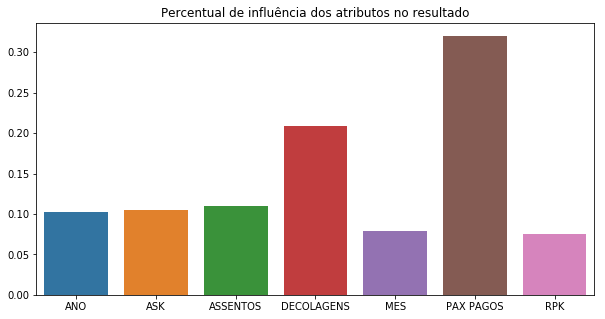

In [27]:
import seaborn as sns

results = pd.read_excel('results.xlsx', sheet_name='FlightClassification1540056663')

results = results[ results['Aeroporto'] == 'SBFZ']

results_df = pd.DataFrame([{
    'ANO': np.average(results.FI_ANO),
    'MES': np.average(results.FI_MES),
    'PAX PAGOS': np.average(results.FI_PAX_PAGOS),
    'DECOLAGENS': np.average(results.FI_DECOLAGENS),
    'ASSENTOS': np.average(results.FI_ASSENTOS),
    'ASK': np.average(results.FI_ASK),
    'RPK': np.average(results.FI_RPK),
}])

plt.figure(figsize=(10, 5))
plt.title('Percentual de influência dos atributos no resultado')
sns.barplot(data=results_df)

#ax = sns.barplot(x="tip", y="day")

# ax.set_yticks(2)
# ax.set_yticklabels(('ASK', 'RPK'))

#for i in range(0, 5):
    #print( json.load(StringIO(results.loc[i]['classification_report'])) )
    #print( json.load(StringIO(results.loc[i]['confusion_matrix'])) )
    #print("")